In [1]:
exp_str = 'landau-zener m-sweep'

from qiskit import IBMQ, transpile #, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.opflow import Y, Z, PauliTrotterEvolution, Suzuki
from qiskit_research import utils

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
IBMQ.load_account()
try:
    provider = IBMQ.get_provider(hub='ibm-q-internal', group='mission-critical', project='bronn')
    backend = provider.get_backend('ibm_lagos')
except:
    provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
    backend = provider.get_backend('ibmq_bogota') # checking gate directions

In [3]:
# job_ids = ['62a90c3412aac3042f0c0c9f', # 5 Trotter steps
#            '62a90d0b0d02290666b04187', # 1 Trotter step
#            '62aa2a4572bc0a1ad5aa3075', # 1 Trotter step, no pulse scaling
#            '62aa31880d02296e1cb048f0', # 5 Trotter steps, no pulse scaling
#            '62aa4669f09ece6d4fe37799'] # 5 Trotter steps

job_ids = ['62acb5bef09eced714e38b2c'] # 30 Trotter steps!

In [4]:
job = backend.retrieve_job(job_ids[-1])
result = job.result()
metadata = result.header
num_shots = result.results[0].shots
counts = result.get_counts()

In [5]:
if metadata.type == 'm-sweep':
    m_range = np.array(metadata.m).round(4)
    w_range = np.array(metadata.ω).round(4)
    g_set = metadata.g
    c_set = metadata.c
    t_set = metadata.t
    Nt = metadata.trotter

In [6]:
Zexp_m_w = []
for midx,_ in enumerate(m_range):
    Zexp_w = []
    for widx,_ in enumerate(w_range):
        count = counts[widx + midx*len(w_range)]
        if '1' in count:
            Zexp_w.append((1 - 2*count['1']/num_shots))
        else:
            Zexp_w.append(1)
            
    Zexp_m_w.append(Zexp_w)

In [7]:
mm = Parameter('m')
gg = Parameter('g')
ham_lz = mm*Z + gg*Y

In [8]:
from sea.utils import build_resonance_ham

cc = Parameter('c')
ww = Parameter('ω')
h_res = build_resonance_ham(ham_lz, cc, ww)

tt = Parameter('t')
U_ham = (tt*h_res).exp_i()

In [9]:
from qiskit.opflow import I, PauliExpectation, Zero

init_state = Zero^2
obsv = I^Z
Zexp_exact = (U_ham @ init_state).adjoint() @ obsv @ (U_ham @ init_state)
diag_meas_op = PauliExpectation().convert(Zexp_exact)

Zexact_m_w = []
param_bind = {
    cc: c_set,
    gg: g_set,
    tt: t_set,
}
for m_set in m_range:
    param_bind[mm] = m_set
    Zexact_w = []
    for w_set in w_range:
        param_bind[ww] = w_set
        Zexact_w.append(np.real(diag_meas_op.bind_parameters(param_bind).eval()))
    Zexact_m_w.append(Zexact_w)

In [10]:
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=Nt)).convert(U_ham)
init_state = Zero^2
obsv = I^Z
Ztrot = (trot_op @ init_state).adjoint() @ obsv @ (trot_op @ init_state)
diag_meas_op = PauliExpectation().convert(Ztrot)

Ztrot_m_w = []
param_bind = {
    cc: c_set,
    gg: g_set,
    tt: t_set,
}
for m_set in m_range:
    param_bind[mm] = m_set
    Ztrot_w = []
    for w_set in w_range:
        param_bind[ww] = w_set
        Ztrot_w.append(np.real(diag_meas_op.bind_parameters(param_bind).eval()))
    Ztrot_m_w.append(Ztrot_w)

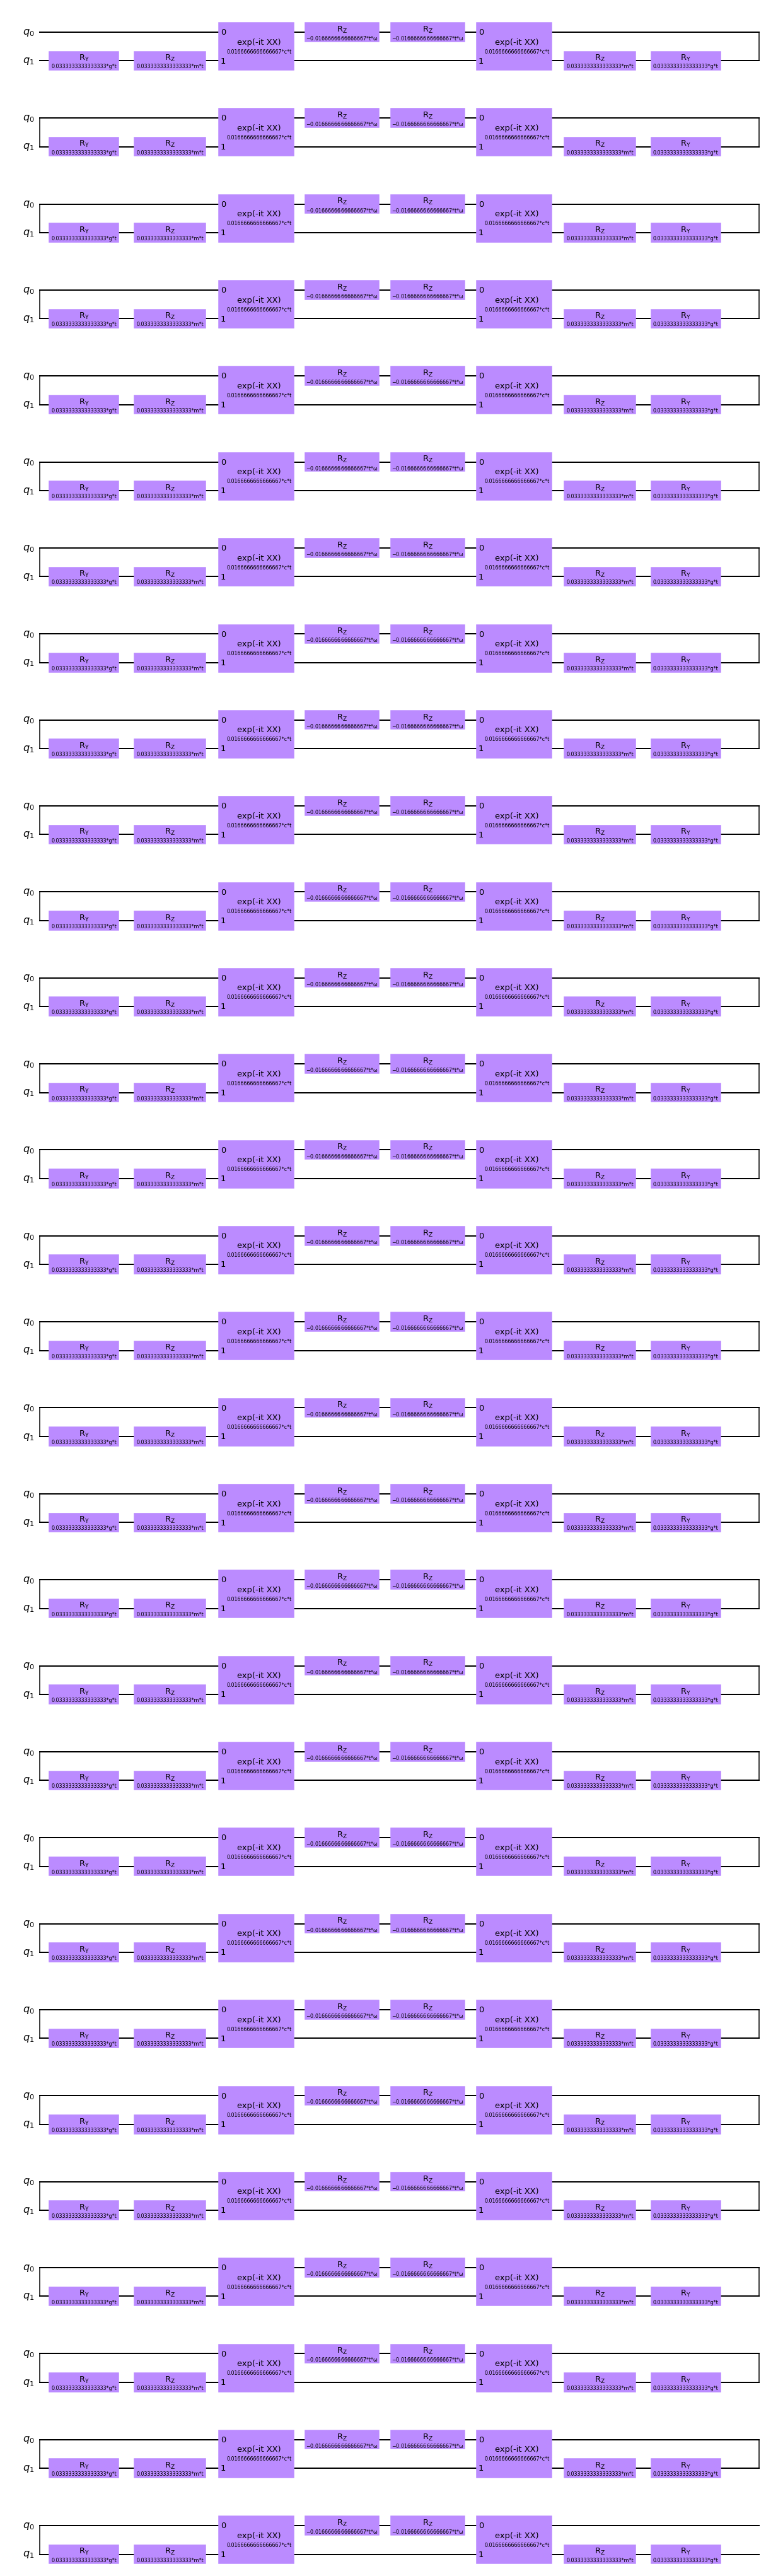

In [11]:
trot_op.to_circuit().draw('mpl')

Text(0.5, 15.0, 'm')

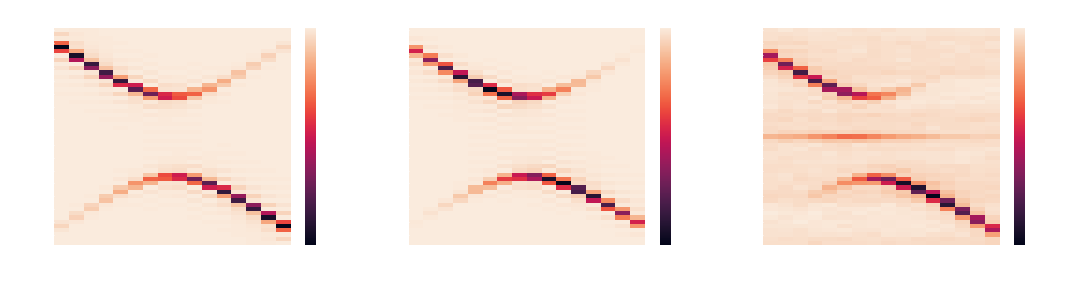

In [12]:
import seaborn as sns
import pandas as pd

df_sim = pd.DataFrame(np.transpose(np.real(Zexact_m_w)), columns=m_range, index=w_range)
df_trot = pd.DataFrame(np.transpose(np.real(Ztrot_m_w)), columns=m_range, index=w_range)
df_exp = pd.DataFrame(np.transpose(np.real(Zexp_m_w)), columns=m_range, index=w_range)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
sns.heatmap(df_sim, cbar_kws={'label': '<Z0>'}, fmt='.2f%', ax=ax1)
sns.heatmap(df_trot, cbar_kws={'label': '<Z0>'}, ax=ax2)
sns.heatmap(df_exp, cbar_kws={'label': '<Z0>'}, ax=ax3)
ax1.set_title('Exact', fontsize=20)
ax2.set_title('Trotterized (Sim)', fontsize=20)
ax3.set_title('Trotterized (Exp)', fontsize=20)
ax1.set_xlabel('m')
ax1.set_ylabel('Energy Difference')
ax2.set_xlabel('m')
ax3.set_xlabel('m')

In [13]:
metadata

namespace(backend_name='ibm_lagos',
          backend_version='1.0.28',
          experiment='landau-zener m-sweep from [-3.0, 3.0]: g=1.5, c=0.1',
          type='m-sweep',
          backend='ibm_lagos',
          layout=[5, 4],
          trotter=30,
          dt=0.3333333333333333,
          c=0.1,
          g=1.5,
          t=10,
          m=[-3.0,
             -2.6,
             -2.2,
             -1.7999999999999998,
             -1.4,
             -1.0,
             -0.5999999999999996,
             -0.19999999999999973,
             0.20000000000000018,
             0.6000000000000001,
             1.0,
             1.4000000000000004,
             1.8000000000000007,
             2.2,
             2.6000000000000005,
             3.0],
          ω=[-8.0,
             -7.68,
             -7.36,
             -7.04,
             -6.72,
             -6.4,
             -6.08,
             -5.76,
             -5.4399999999999995,
             -5.12,
             -4.8,
             -4

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table